<h3><b>Clustering the Countries by using Unsupervised Learning for HELP International</b></h3>

**Objective:** <br>
To categorize the countries using socio-economic and health factors that determine the overall development of the country.

**About organization:** <br>
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

**Problem Statement:** <br>
HELP International have been able to raise around $10,000,000. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorize the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

Dataset Source: https://kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data

# Libraries

In [1]:
!pip3 install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Basic libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport
from math import pi

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Data Ingestion

In [4]:
# Read data from the csv file
df = pd.read_csv("data/country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**Features:**
- `country`: Name of the country
- `child_mort`: Death of children under 5 years of age per 1000 live births
- `exports`: Exports of goods and services per capita. Given as %age of the GDP per capita
- `health`: Total health spending per capita. Given as %age of GDP per capita
- `imports`: Imports of goods and services per capita. Given as %age of the GDP per capita
- `income`: Net income per person
- `inflation`: The measurement of the annual growth rate of the Total GDP
- `life_expec`: The average number of years a new born child would live if the current mortality patterns are to remain the same
- `total_fer`: The number of children that would be born to each woman if the current age-fertility rates remain the same
- `gdpp`: The GDP per capita. Calculated as the Total GDP divided by the total population

Aside from `country`, which is the unique identifier in this data, the other features are either integers or floats

Based on these features, the countries that urgently needs financial help should have the following characteristics:
- High Child Mortality (`child_mort`): Countries with high child mortality rates indicate poor health services, insufficient resources for child care, and potentially unstable living conditions.
- Low Health Spending (`health`): Countries that spend a low percentage of their GDP on health are likely to have insufficient health services, which can exacerbate child mortality and lower life expectancy.
- Low Income (`income`): Low-income countries struggle to meet basic needs, and a low per capita income can lead to a lack of access to essential services such as health care, education, and food.
- Low Life Expectancy (`life_expec`): A lower life expectancy indicates higher mortality rates, poor living conditions, and inadequate health care.
- High Fertility Rate (`total_fer`): High fertility rates, coupled with low income, may indicate challenges in providing for a growing population, putting additional strain on already limited resources.
- Low GDP per capita (`gdpp`): A low GDP per capita is another indicator of poverty and insufficient financial resources to provide for the country's population.
- Low Imports and Exports (`imports` & `exports`): A low number of imports and exports implies that a country has a poor trade industry that it can't afford to export and import products.
- High Inflation (`inflation`): High inflation indicates an unstable economy, which can lead to increased costs of living, reduce purchasing power, and create economic uncertainty.

In [5]:
# Column Categorization
drop_cols = []
num_cols = list(set(df.select_dtypes(include = np.number).columns.tolist()) - set(drop_cols))
cat_cols = list(set(df.select_dtypes(exclude = np.number).columns.tolist()) - set(drop_cols))
rem_cols = list(set(df.columns.tolist()) - set(num_cols) - set(cat_cols))

print('Numerical Columns:\n', num_cols)
print('\nCategorical Columns:\n', cat_cols)
print('\nRemaining Columns:\n', rem_cols)

Numerical Columns:
 ['total_fer', 'health', 'income', 'life_expec', 'exports', 'child_mort', 'imports', 'inflation', 'gdpp']

Categorical Columns:
 ['country']

Remaining Columns:
 []


## Data Quality

### Summary Statistics

In [6]:
# Check for summary statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


From the summary stats of numerical variables, the features are not in the same scale as each other. Recommended to use feature scaling before ingesting to the model.

In [7]:
# Check for summary statistics
df['country'].describe()

count             167
unique            167
top       Afghanistan
freq                1
Name: country, dtype: object

`country` variable is unique, with 167 countries included in the data.

### Missing data

In [8]:
# Check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


No missing data found

### Duplicate data

In [9]:
# Check for duplicates
df.duplicated().value_counts()

False    167
Name: count, dtype: int64

No duplicated data found

# Exploratory Data Analysis

## Auto-EDA Report

In [10]:
# Auto-EDA using Pandas Profiling
profile = ProfileReport(df)
profile.to_file("assets/auto_eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Critical observations from the generated report:
- Most features are highly correlated with one another
- `country` has unique values, same observation from the data's summary stats

## Distribution of Numerical Variables

Taking a closer look at the distribution of all the features except the unique identifier (`country`)

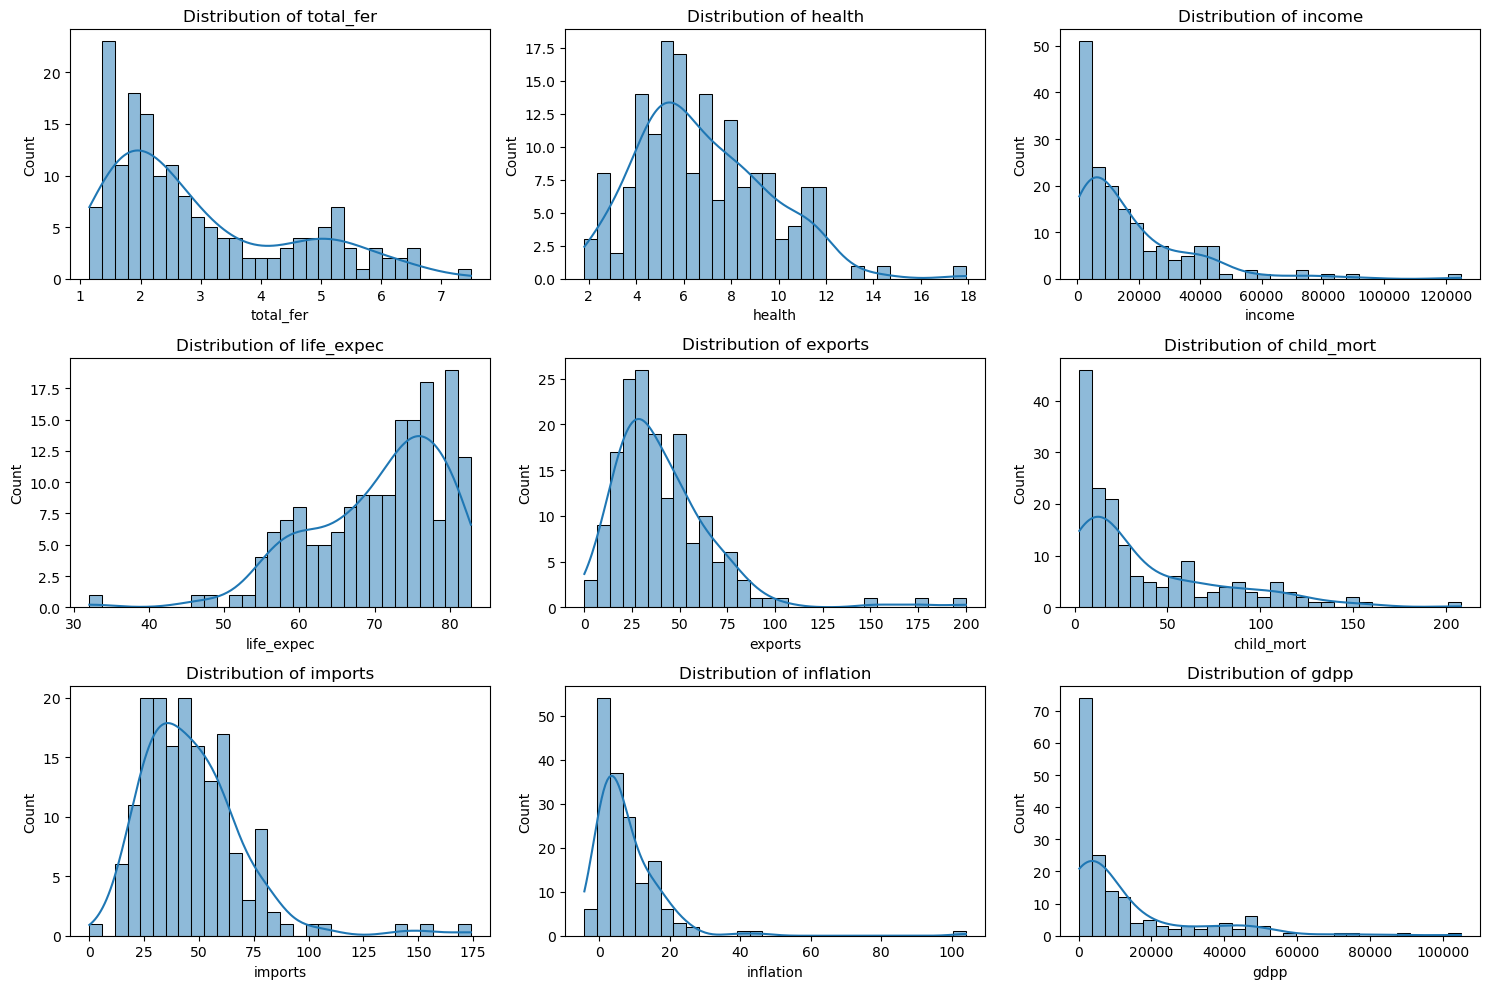

In [11]:
# Generate histogram plots for all numerical variables
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Observations:
- The majority of countries in this dataset seem to be economically and socially underdeveloped, with issues related to low income, high child mortality, low life expectancy, and lower health spending.
- The presence of outliers, particularly in variables such as income, exports, imports, and GDP, suggests that a small number of countries have significantly better socio-economic conditions.
- Many countries seem to face health and economic challenges, which could be critical factors when deciding which countries need aid the most.

## Correlation Analysis

In [16]:
def correlation_analysis(df):
    """
    Extract the correlation matrix

    Parameters:
    - df: pandas DataFrame containing the data
    """
    # Correlation Matrix
    num_cols = list(set(df.select_dtypes(include = np.number).columns.tolist()) - set(drop_cols))
    corr_matrix = df[num_cols].corr()

    # Create the heatmap using Plotly
    fig = px.imshow(corr_matrix.round(2), 
                    text_auto=True, 
                    x=corr_matrix.columns, 
                    y=corr_matrix.columns, 
                    zmax=1, 
                    zmin=-1, 
                    color_continuous_scale='RdBu_r')

    # Minor edits in the Visualization
    fig.update_layout(
        title={
            'text': f"<b>Correlation Heatmap</b>",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Features",
        yaxis_title="Features",
    )

    # Show the Correlation Heatmap
    fig.show()

In [17]:
# Correlation Heatmap
correlation_analysis(df)

Observation:
- Most features have relationship with each other, recommended to do PCA before modelling
- Countries with higher `income` also have higher `gdpp`
- Countries with higher `life_expec` possessed lower `total_fer` and lower `child_mort`
- Countries with higher `exports` also have higher `imports`

# Preprocessing

## Feature Scaling

In [18]:
# Set the country as index
df = df.set_index("country")
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Based on the summary stats, the features are found to be not in scale with each other, so feature scaling is needed. In this case, we'll be using sklearn's Standard Scaler

In [19]:
# Feature Scaling with Standard Scaler
scaler = StandardScaler()
scaler.fit(df)

preproc_df = scaler.transform(df)
preproc_df = pd.DataFrame(preproc_df, columns=df.columns, index=df.index)
preproc_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## Dimensionality Reduction

From the correlation analysis, most of the features seems to be highly correlated with each other. To avoid data leakage, perform PCA to reduce the number of features.

In [40]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(preproc_df)
pca_df = pca.transform(preproc_df)
pca_df = pd.DataFrame(pca_df, columns=["PCA1", "PCA2"], index=df.index)
pca_df.head()

,PCA1,PCA2
country,,
Afghanistan,-2.913025,0.095621
Albania,0.429911,-0.588156
Algeria,-0.285225,-0.455174
Angola,-2.932423,1.695555
Antigua and Barbuda,1.033576,0.136659


Reduced to 2 PCA components for better interpretability & visualization for the Clustering analysis later.

In [41]:
# Show the correlation heatmap of the reduced features
correlation_analysis(pca_df)

After dimensionality reduction, there's now no correlation between features, which signifies that both are unique predictors for modelling later.

# Modelling

## Optimal Number of Clusters (K)

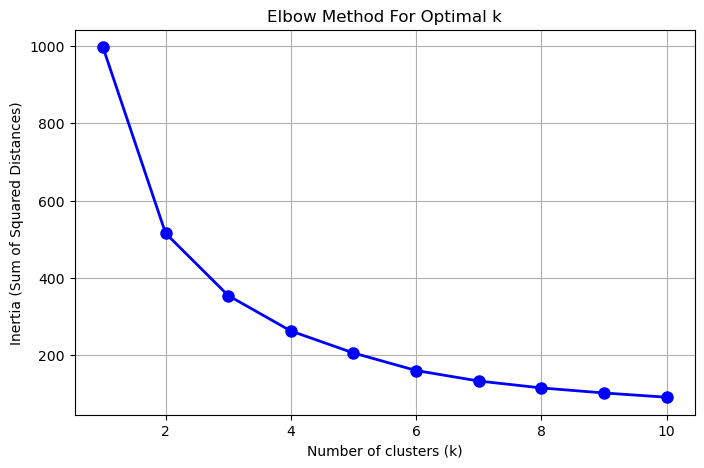

In [46]:
# Elbow method
inertia = []
K = range(1, 11)  # Cluster range (1 to 10)

# Loop over the range of cluster numbers and fit KMeans
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)  # Inertia measures the sum of squared distances

# Plotting the elbow curve
fig = plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

There is a noticeable "elbow" at k = 2 or k = 3, indicating a significant drop in inertia (sum of squared distances) at this point, followed by a more gradual decrease as the number of clusters increases

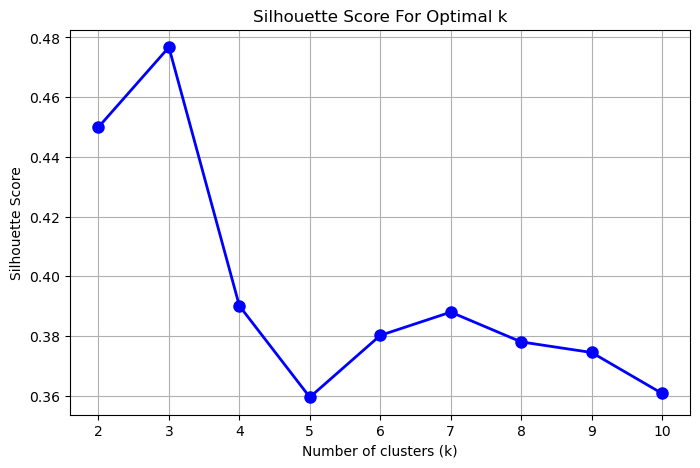

In [47]:
# Silhouette Score
silhouette_scores = []
K = range(2, 11)  # Cluster range (2 to 10)

# Loop over the range of cluster numbers and fit KMeans
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    labels = kmeans.labels_  # Get cluster labels
    silhouette_avg = silhouette_score(pca_df, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
fig = plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid(True)
plt.show()

The highest silhouette score occurs at k = 3, suggesting that the clustering quality is best when using 3 clusters

Based on both the elbow method and the silhouette score, the optimal number of clusters is likely **k = 3**.

## Building the Model

In [48]:
# Initialize KMeans with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the model
kmeans.fit(pca_df)

# Assign cluster labels 
pca_df['cluster'] = kmeans.labels_
pca_df['cluster'].head()

country
Afghanistan            1
Albania                0
Algeria                0
Angola                 1
Antigua and Barbuda    0
Name: cluster, dtype: int32

In [49]:
# Number of countries per cluster
pca_df['cluster'].value_counts()

cluster
0    92
1    72
2     3
Name: count, dtype: int64

## Evaluate the Model

For optimal_k = 3, the average silhouette score is 0.47671881513922454


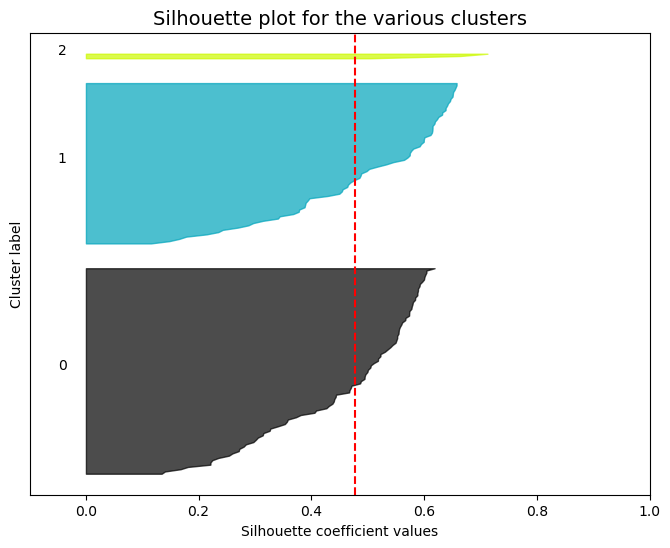

In [50]:
# Compute the average silhouette score
silhouette_avg = silhouette_score(pca_df, pca_df["cluster"])
print(f"For optimal_k = {optimal_k}, the average silhouette score is {silhouette_avg}")

# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(pca_df, pca_df["cluster"])

# Create the silhouette plot
fig, ax = plt.subplots(figsize=(8, 6))

# Set the limits for the plot
y_lower = 10
for i in range(optimal_k):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[pca_df["cluster"] == i]
    
    # Sort the silhouette values for each cluster
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Fill between plot for each cluster silhouette score
    color = cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plot with cluster numbers in the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples separation between clusters

# Title and labels
ax.set_title("Silhouette plot for the various clusters", fontsize=14)
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all samples
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

# Clear the y-axis labels and ticks
ax.set_yticks([])

# Set the x-axis range
ax.set_xlim([-0.1, 1])

plt.show()

Observation:
- Cluster 0 (gray) is the largest cluster and has mostly high silhouette scores, indicating good separation from other clusters. 
- Cluster 1 (blue) has slightly lower silhouette scores, but most points are still well-separated. 
- Cluster 2 (yellow) contains only a few points, and the silhouette scores are close to the average. 
- The majority of points in all clusters have silhouette scores above 0.4, suggesting that the clustering is generally effective, though cluster 2's size and shape indicate potential outliers or noise.

## Cluster Characteristics

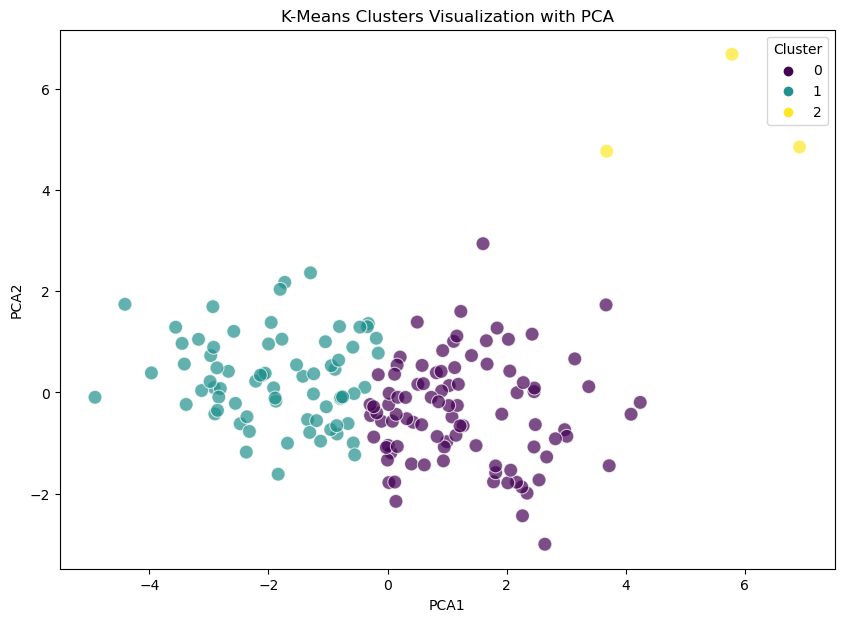

In [87]:
# Scatterplot
fig = plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', 
                data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clusters Visualization with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Observations:
- Clusters 0 and 1 appear to represent the main structure of the data, with a clear boundary between them.
- Cluster 2 consists of only a few outliers that are distant from the main data points. These could potentially be removed or treated as noise.

In [89]:
# Merge the cluster to the original dataframe
kmeans_df = df.reset_index().merge(pca_df.reset_index()[["country", "cluster"]], on="country", how="left")
kmeans_df = kmeans_df.set_index("country")
kmeans_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0
...,...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0


In [90]:
def box_plot_cluster_vs_feature(df, column):
    """
    Reusable box plot function for the distribution of each clusters per feature

    Parameters:
    - df: pandas DataFrame containing the data
    - column: The name of the column to plot against the 'Class' column
    """
    # Create the box plot using plotly express
    fig = px.box(df, x="cluster", y=column, 
                 title=f"Distribution of {column} per Cluster",
                 width=1000)
    
    # Update the layout for better visualization
    fig.update_layout(
        title={
            'text': f"<b>Distribution of {column.title().replace('_', ' ')} per Cluster</b>",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="<b>Cluster</b>",
        yaxis_title=f"<b>{column.title().replace('_', ' ')}</b>",
        boxmode='group'
    )
    
    # Show the plot
    fig.show()

In [91]:
# Distribution of Income per Cluster
box_plot_cluster_vs_feature(kmeans_df, column="income")

Observation:
- Most countries in cluster 1 have income lower than $10k (Low Income)
- Countries in cluster 2 have income on the higher end than other clusters (High Income), this is the outlier cluster
- Cluster 0 is in range between cluster 1 and cluster 0 (Medium Income)

Based on the correlation heatmap, countries in cluster 1 are in the lower end in terms of GDP per capita as well.

In [92]:
# Distribution of Child Mortality per Cluster
box_plot_cluster_vs_feature(kmeans_df, column="child_mort")

Observation:
- Cluster 2: Low Child Mortality
- Cluster 0: Low-Medium Child Mortality
- Cluster 1: High Child Mortality

Based on the correlation heatmap, countries in cluster 1 would have higher fertility rate and lower life expectancy.

In [93]:
# Distribution of Exports per Cluster
box_plot_cluster_vs_feature(kmeans_df, column="exports")

Observation:
- Cluster 1: Low Exports
- Cluster 0: Medium Exports
- Cluster 2: High Exports

Based on the correlation heatmap, countries in cluster 1 would also have lower imports.

In [78]:
# Distribution of Inflation per Cluster
box_plot_cluster_vs_feature(kmeans_df, column="inflation")

Observation:
- Cluster 0: Low Inflation
- Cluster 2: Low Inflation
- Cluster 1: High Inflation

In [94]:
# Distribution of Health per Cluster
box_plot_cluster_vs_feature(kmeans_df, column="health")

Observation:
- Cluster 1: Low Health Spending
- Cluster 2: Medium Health Spending
- Cluster 0: Medium-High Health Spending

Based on the criteria for countries that urgently needs financial asssistance defined at the beginning of this notebook, cluster 1 seems to possess all of that criteria.
- Low `health`, `exports`, `imports`, `life_expec`, `income`, `gdpp`
- High `inflation`, `child_mort`, `total_fer`

In [122]:
# Chloropeth of the Clusters
kmeans_df['cluster'] = kmeans_df['cluster'].apply(lambda x: str(x))
fig = px.choropleth(kmeans_df.reset_index()[['country', 'cluster']],
                    locationmode='country names',
                    locations='country',
                    color='cluster',
                    color_discrete_map={'0': 'Yellow',
                                        '1': 'Red',
                                        '2': 'Green'},  
                    hover_name='country',  
                    width=1000,
                    height=500
                   )

# Update the geos for better fit
fig.update_geos(fitbounds="locations", visible=True)

# Update layout for a polished look
fig.update_layout(
    title={
        'text': '<b>Categorization of Countries that Urgently Requires Financial Assistance</b>',
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Clusters',
)

# Show the map
fig.show()

Most of the countries in cluster 1 are in Africa, South Asia, and Southeast Asia.